<h1><center><font color='red'>Dos Santos-Coutinho Simulation</font></center></h1>

This Jupyter notebook shows how <b>Ben Maldonado</b>, worked through the <b><i>Dos Santos-Coutinho Simulation</i></b> to create a <i>Decision Tree Regressor</i> based on the simulation data. Ben worked as a member of the larger group working on Milestone 1 of the <b>Predicting Virus Project.</b>

Much of the code in the beginning of this notebook is <i><b>not my own code.</b></i> It was taken from Dr. Giabenelli's own notebook on this model. I have properly notated what <i>is</i> and <i>is not</i> my code.

# Part 1. The Simulation

Based on both Dr. Giabanelli's notebook and original <i>Dos Santos</i> paper, here are the rules that guide the HIV model:

__Parameters:__

|  __Symbol__ | __Definition__                                                        |     __Value__    |
|:-----------:|-----------------------------------------------------------------------|:----------------:|
|     $L$     | Number of cells                                                       |  $800\times800$  |
|  $P_{HIV}$  | Percentage of initially infected cells                                | $5\times10^{-2}$ |
| $P_{infec}$ | Probability of an infected cell replacing a dead cell                 | $1\times10^{-5}$ |
|  $P_{repl}$ | Probability a healthy cell replaces a dead cell                       |       $.99$      |
|     $R$     | Percentage of neighboring $I_2$-cells needed to infect a healthy cell |      $50\%$      |
|    $\tau$   | Time-steps before infected-$I_1$ discovered by immune system          |         4        |
|    $T$      | Number of time steps in the model                                     |      $600$       |
|    $H$      | Denotes a healthy cell                                                |    $0$ in cell   |
|   $A_1$     | Denotes an infected cell _not discovered by immune system_            |    $4$ in cell   |
|   $A_2$     | Denotes an infected cell _that has been marked by immune system_      |    $1$ in cell   |
|    $D$      | Denotes a dead cell                                                   |    $8$ in cell   |
  
<p style="text-align: center;">Table 1: Parameters of Dos Satnos Model</p>


These values are slightly changed from the ones originally in the Dos Santos Model. The original model used a grid that was 700 by 700, where our model uses an 800 by 800 grid. This is because new research has pointed to any model under <b>800 by 800</b> in size is not as likely to be statistically significant. I also lowered the number of time steps from 12*52 to just <i>600</i> total timesteps.


__Ruleset:__
1. $H$ --> $A_1$ when there is one or more $A_1$ around it
2. $H$ --> $A_1$ when there are 2 < R < 8 A2 cells around it with no A1's around it
    * R is 4 in this case, so there must be 4 A2 cells around a healthy cell to infect it
3. $A_1$ --> $A_2$ after time $\tau$ has passed
4. $A_2$ --> $D$ after 1 time step
5. $D$ --> $H$ with probability $P_{repl}$
6. $D$ --> $A_1$ with probabiliy $P_{repl}$ x $P_{infec}$

## Here is the code for the model.

In [2]:
# NOT MY CODE

import numpy as np
from numba import jit, prange

# Constants for the model
# these constants essentially allow us to check for whether or not a cell is infected or dead based on its value in the cell
CELL_H  = 0
CELL_D  = 8
CELL_A1 = 4
CELL_A2 = 1

In [2]:
# this cell was largely from the original notebook, I just commented and added some of the optimizations spoken of in 
# "Optimizating Discrete Simulations of the Spread of HIV-1 to Handle Billions of Cells on a Workstation"


@jit(nopython=True, parallel=True)
def simulation_step(grid, buffer, taugrid, P_repl, P_infec, tau1):
    """
    Grid is the current grid of our simulation
    Buffer is the NEXT timestep that will eventually replace this one
    taugrid is the time tracker for transferring A1 -> A2 based on tau1
    P_repl is our probability of replacing a dead cell with a healthy one (.99 for this simulation run)
    P_infec is our probability of replacing a dead cell with an infected one (.00001 for this simulation run)
    tau1 is the time it takes for an A1 -> A2 (4 time steps for this run)
    """
    
    # the counts of healthy and dead cells
    healthy = 0
    dead    = 0
    
    # loop through every cell on the model (other rows or columns, depending on .shape)
    for i in prange(1, grid.shape[0]-1):
        for j in prange(1, grid.shape[1]-1):
            # current cell
            cell = grid[i,j]
            
            if cell == CELL_H:
                # more healthy ones!
                healthy += 1
                
                # checks Moore neighborhood to see if this cell stays healthy
                # & sets each bit of the output value to 1 if both input bits for that particular place are 1
                # this basically means that each cell in the neighborhood will either be 4 right away, or all 1's and will
                # thus become infected
                if ((grid[i-1,j-1] & 5) + (grid[i-1,j] & 5) + (grid[i-1,j+1] & 5) +
                    (grid[i,  j-1] & 5)                     + (grid[i,  j+1] & 5) +
                    (grid[i+1,j-1] & 5) + (grid[i+1,j] & 5) + (grid[i+1,j+1] & 5)) >= 4:
                        buffer[i,j] = CELL_A1
                
                # if this condition is not true, the cell remains healthy!

            elif cell == CELL_A1:
                taugrid[i,j] += 1
                if taugrid[i,j] == tau1:
                    taugrid[i,j] = 0
                    buffer[i,j] = CELL_A2

            # A2 dies at this timestep
            elif cell == CELL_A2:
                buffer[i,j] = CELL_D

            else: # elif value == CELL_D:
                # more dead ones!
                dead += 1
                
                # our replacement probabilities from before
                if np.random.random() < P_repl:
                    if np.random.random() < P_infec:
                        buffer[i,j] = CELL_A1
                    else:
                        buffer[i,j] = CELL_H
      
    # cannot switch the grid and buffer within the step because the scope of the references does not exist beyond this function
    # grid[:,:] = buffer[:,:]
    # grid, buffer = buffer, grid
    # buffer = grid.copy()
            

    # return the number of healthy, number of infected, number of dead
    # also updates the grids that we input so we have our original timestep, 
    # our buffer that will become the next timestep, and our taugrid for timings
    return healthy, (grid.shape[0]-2)*(grid.shape[1]-2)-healthy-dead, dead

In [3]:
# this cell once again implements largely most of the code from the previous notebook with comments and optimizations. I also
# cut a lot of the unnecessary "fat" from the code that wasn't directly contributing to simulations for our purposes

def run(timesteps, replications, L = 700, P_HIV = 0.05, P_repl = 0.99, P_infec = 1e-05, tau1 = 4):
    """
    Runs the model.
    Timesteps is the number of timesteps in this model
    Replications is the number of times to run the ENTIRE model
    L is the length of one side of the simulation grid 
    P_HIV is the starting probability for an HIV cell to be infected (5% right now)
    
    stepFunc is never used locally :(
    """
    
    # create the initial grid using the P_HIV
    @jit
    def init_grid():
        # define grid as 0 since all H cells are 0
        grid = np.zeros((L+2, L+2), dtype=np.uint8)
    
        # seeding the virus
        for i in prange(1, grid.shape[0]-1):
            for j in prange(1, grid.shape[1]-1):
                if np.random.random() < P_HIV:
                    grid[i,j] = CELL_A1

        return grid, np.zeros_like(grid)
    
    
    def periodic_borders(grid):
        grid[1:-1, 0] = grid[1:-1,-2]
        grid[1:-1,-1] = grid[1:-1, 1]
        grid[ 0,1:-1] = grid[-2,1:-1]
        grid[-1,1:-1] = grid[ 1,1:-1]
        grid[ 0, 0]   = grid[-2,-2]
        grid[ 0,-1]   = grid[-2, 1]
        grid[-1, 0]   = grid[ 1,-2]
        grid[-1,-1]   = grid[ 1, 1]
       
    
    # THIS IS MY CODE HERE to download the 2D numpy arrays
    def save_array(grid, run, t):
        file_name = open("Simulation Runs/{}_{}.npz".format(run, t),'wb')
        np.savez_compressed(file_name, arr_0=grid)
        file_name.close()
    
    # file to write the states out onto
    f_out = open("states.csv",'w')
    f_out.write("run,timestep,healthy,infected,dead\n")
    
    for run in range(replications):
        grid, taugrid = init_grid()
        buffer = grid.copy()

        for t in range(timesteps):
            periodic_borders(grid)
            
            # gives a simplified idea of what is happening at each time step without needing to worry about mining this data each timestep
            healthy, infected, dead = simulation_step(grid, buffer, taugrid, P_repl, P_infec, tau1)
            f_out.write("{},{},{},{},{}\n".format(run, t, healthy, infected, dead))
            
            # at the end of each loop, save the grid again
            save_array(grid, run, t)

            # the optimization, grid, buffer = buffer, grid does not work as well here.
            # first, we would need to make sure that buffer becomes a copy of grid so that the info that was previously in grid
            # doesn't carry over into the next step of the simulation. (That is why I was having issues with not being able to
            # replicate the patterns) However, since we are still copying the data, it would simply be faster to copy the data from buffer into 
            # the grid directly
            grid[:,:] = buffer[:,:]
            
    f_out.close()
    return results_H, results_A, results_D

In [4]:
# this cell is not my code, but I did cut some "fat" from it
def plot_pic(file_name):
    import numpy as np
    import scipy.misc as smp
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    picture = np.load(file_name)['arr_0']
    
    fig = plt.figure(figsize=(8, 15))
    columns = 3
    rows = 2

    data = np.zeros((800,800,3), dtype=np.uint8)
    # Convert picture array to image
    for row in range(0, len(data)):
        for col in range(0, len(data)):
            pixel = picture[row][col]
            if pixel == 0:
                data[row, col] = [255, 255, 255] # CELL_H  == WHITE
            elif (pixel == 8):
                data[row, col] = [0, 0, 0]       # CELL_D  == BLACK
            elif (pixel == 4):
                data[row, col] = [0, 128, 0]     # CELL_A1 == GREEN
            elif (pixel == 1):
                data[row, col] = [0, 255, 0]     # CELL_A2 == LIME

    tmp = fig.add_subplot(rows, columns, 1)
    plt.imshow(data)

    plt.show()  

## Let's run some models!

In [5]:
# run the model one time to see how long it takes to run and load the different numpy arrays
# currently commented out to avoid running 1000 simulations again
# %time results_H, results_A, results_D = run(601, 1000, L=800)

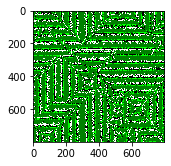

In [6]:
# Test visualization
plot_pic("Simulation Runs/999_600.npz")

## Visualizing the dataset to be sure it follows Dos Santos' theoretical values

In [7]:
import pandas as pd

df = pd.read_csv("states.csv")

In [8]:
# load in the healthy, infected, and dead values for each timestep

replications = 1000
timesteps = 601

results_H = np.zeros((replications, timesteps))
results_A = np.zeros((replications, timesteps))
results_D = np.zeros((replications, timesteps))

counter = 0
for run in range(replications):
    for t in range(timesteps):
        results_H[run,t] = df["healthy"].iloc[counter]
        results_A[run,t] = df["infected"].iloc[counter]
        results_D[run,t] = df["dead"].iloc[counter]
        counter += 1

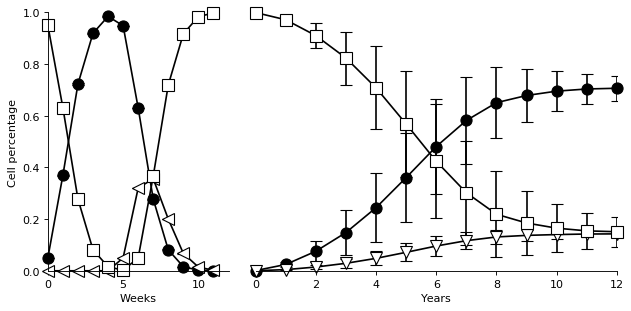

In [9]:
# this code is directly copied from the other notebook

%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, sharey=True,
                       gridspec_kw = {'width_ratios':[1, 2]},
                       figsize=(8,4), dpi=80)

yscale = 800**2
xscale = np.arange(0,12)

ax[0].set_xlabel("Weeks")
ax[0].set_ylabel("Cell percentage")
ax[0].errorbar(xscale, np.mean(results_A, axis=0)[:12] / yscale, np.std(results_A, axis=0)[:12] / yscale, marker='o', clip_on=False, markersize=10, capsize=5, color='k')
ax[0].errorbar(xscale, np.mean(results_D, axis=0)[:12] / yscale, np.std(results_D, axis=0)[:12] / yscale, marker='<', clip_on=False, markersize=10, capsize=5, color='k', markerfacecolor='white')
ax[0].errorbar(xscale, np.mean(results_H, axis=0)[:12] / yscale, np.std(results_H, axis=0)[:12] / yscale, marker='s', clip_on=False, markersize=10, capsize=5, color='k', markerfacecolor='white')
ax[0].axis([0, 12, 0, 1])
ax[0].xaxis.set_ticks(np.arange(0,12,5))

indices = [12] + list(range(52,601,52)) + [-1]
xscale = np.arange(0,13)

ax[1].set_xlabel("Years")
ax[1].errorbar(xscale, np.mean(results_A, axis=0)[indices] / yscale, np.std(results_A, axis=0)[indices] / yscale, marker='o', clip_on=False, markersize=10, capsize=5, color='k')
ax[1].errorbar(xscale, np.mean(results_D, axis=0)[indices] / yscale, np.std(results_D, axis=0)[indices] / yscale, marker='v', clip_on=False, markersize=10, capsize=5, color='k', markerfacecolor='white')
ax[1].errorbar(xscale, np.mean(results_H, axis=0)[indices] / yscale, np.std(results_H, axis=0)[indices] / yscale, marker='s', clip_on=False, markersize=10, capsize=5, color='k', markerfacecolor='white')
ax[1].axis([0, 12, 0, 1])
ax[1].yaxis.set_visible(False)

for i in range(2):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    
ax[1].spines['left'].set_visible(False)

fig.tight_layout()
fig.subplots_adjust(wspace=0.1)

fig.savefig("dosSantosReplicate.png")

The above image is my generated Dos Santos photo. Below is the original graph of the infection from the Dos Santos paper. They match exactly!

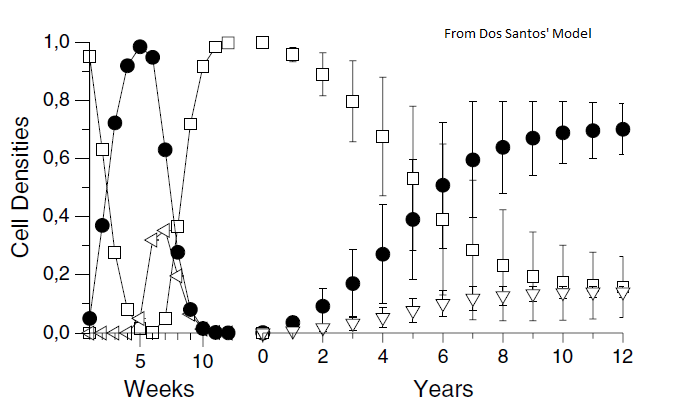

In [10]:
from IPython.display import Image
Image("dossantosOriginal.png")

# Part 2. Image Feature Extraction

The image processing will happen through __SciKit Image__. First, in order to use this, we have to convert the 2D numpy arrays from Part 1 into grayscale images so we can extract features. The next few cells will be used to test different algorithms for feature extraction.

In [11]:
from skimage import feature as skif
from skimage.color import rgb2gray
#load up images from first simulation and convert them to full depth color images
simulations = []
# only load up every 50 simulation slides
for t in range(0,601,50):
    picture = np.load("Simulation Runs/0_{}.npz".format(t))['arr_0']
    data = np.zeros((800,800,3), dtype=np.uint8)
    # Convert picture array to image
    for row in range(len(data)):
        for col in range(len(data)):
            pixel = picture[row][col]
            if pixel == 0:
                data[row, col] = [255, 255, 255] # CELL_H  == WHITE
            elif (pixel == 8):
                data[row, col] = [0, 0, 0]       # CELL_D  == BLACK
            elif (pixel == 4):
                data[row, col] = [0, 128, 0]     # CELL_A1 == GREEN
            elif (pixel == 1):
                data[row, col] = [0, 255, 0]     # CELL_A2 == LIME
    # convert the colored images to grey scale
    simulations.append(rgb2gray(data))

In [12]:
# blobs
for t in range(len(simulations)):
    print("Method: blob_doh, Timestep {}: {}".format(t, skif.blob_doh(simulations[t])))     # blob_doh
    print("Method: blob_dog, Timestep {}: {}".format(t, skif.blob_dog(simulations[t])))     # blob_dog
    print("Method: blob_log, Timestep {}: {}".format(t, skif.blob_log(simulations[t])))     # blob_log
    
# it seems that blob_doh is doing well, getting promising results for all of the tests. It does, however, take a while to run
# blob_dog is not providing anything for many of the timesteps
# blob_log is not providing enough information either

Method: blob_doh, Timestep 0: [[797. 737.   1.]
 [797. 728.   1.]
 [797. 725.   1.]
 ...
 [  0.  58.   1.]
 [  0.  53.   1.]
 [  0.  49.   1.]]
Method: blob_dog, Timestep 0: []
Method: blob_log, Timestep 0: []
Method: blob_doh, Timestep 1: [[797.         407.           4.22222222]
 [797.         397.           4.22222222]
 [797.         328.           4.22222222]
 [797.          57.           4.22222222]
 [797.          47.           4.22222222]
 [795.         314.           7.44444444]
 [782.         325.          10.66666667]
 [780.         401.           7.44444444]
 [779.          48.           1.        ]
 [775.         790.          30.        ]
 [774.          48.           1.        ]
 [734.         774.          10.66666667]
 [732.          51.           7.44444444]
 [723.         795.           7.44444444]
 [585.         274.           7.44444444]
 [585.         194.           7.44444444]
 [582.         230.           1.        ]
 [563.         669.           7.44444444]
 [56

Method: blob_dog, Timestep 2: []
Method: blob_log, Timestep 2: [[774.          98.           1.        ]
 [770.          98.           1.        ]
 [744.         278.           1.        ]
 [740.         278.           1.        ]
 [735.         448.           1.        ]
 [735.         393.           1.        ]
 [735.         389.           1.        ]
 [735.         357.           1.        ]
 [735.         353.           1.        ]
 [735.         278.           1.        ]
 [687.         727.           1.        ]
 [687.          98.           1.        ]
 [632.         319.           1.        ]
 [632.         311.           1.        ]
 [632.         307.           1.        ]
 [632.         272.           1.        ]
 [632.         268.           1.        ]
 [632.         172.           1.        ]
 [632.         168.           1.        ]
 [632.         149.           1.        ]
 [631.         321.           1.        ]
 [610.         716.           1.        ]
 [610.       

Method: blob_dog, Timestep 3: []
Method: blob_log, Timestep 3: [[790.         498.           1.        ]
 [786.         498.           1.        ]
 [769.         677.           1.        ]
 [769.         148.           1.        ]
 [765.         677.           1.        ]
 [765.         148.           1.        ]
 [742.         677.           1.        ]
 [738.         677.           1.        ]
 [731.         148.           1.        ]
 [722.         141.           1.        ]
 [722.         100.           1.        ]
 [722.          96.           1.        ]
 [717.         141.           1.        ]
 [713.         141.           1.        ]
 [703.         149.           1.        ]
 [691.         219.           1.        ]
 [691.         157.           1.        ]
 [685.         498.           1.        ]
 [685.         462.           1.        ]
 [685.         458.           1.        ]
 [685.         149.           1.        ]
 [682.         152.           1.        ]
 [680.       

Method: blob_dog, Timestep 4: []
Method: blob_log, Timestep 4: [[772. 191.   1.]
 [772. 110.   1.]
 [772. 106.   1.]
 ...
 [ 23. 548.   1.]
 [ 14. 548.   1.]
 [ 10. 548.   1.]]
Method: blob_doh, Timestep 5: [[797.         250.           4.22222222]
 [797.         240.           4.22222222]
 [784.         773.          30.        ]
 ...
 [ 27.         790.           4.22222222]
 [ 25.         244.           7.44444444]
 [ 21.         797.           4.22222222]]
Method: blob_dog, Timestep 5: [[551.         593.          42.94967296]
 [375.         799.          42.94967296]
 [368.         412.          42.94967296]
 [193.         556.          42.94967296]]
Method: blob_log, Timestep 5: [[688. 787.   1.]
 [679. 482.   1.]
 [679. 478.   1.]
 ...
 [ 22. 796.   1.]
 [ 22. 241.   1.]
 [ 22.  16.   1.]]
Method: blob_doh, Timestep 6: [[797.         300.           4.22222222]
 [797.         290.           4.22222222]
 [795.         732.           7.44444444]
 ...
 [ 75.         741.           7

In [13]:
# corners
for t in range(len(simulations)):
    print("Method: corner_fast, Timestep {}: {}".format(t, skif.corner_fast(simulations[t])))     # corner_fast
    print("Method: corner_harris, Timestep {}: {}".format(t, skif.corner_harris(simulations[t])))     # corner_harris
    print("Method: corner_kitchen_rosenfeld, Timestep {}: {}".format(t, skif.corner_kitchen_rosenfeld(simulations[t])))     # corner_kitchen_rosenfeld

# as we can see below, these corner algorithms seem to be pulling a lot of information!
# nice and fast as well. The corner_fast algorithm seems to have the best information

Method: corner_fast, Timestep 0: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Method: corner_harris, Timestep 0: [[6.96742684 7.75647494 1.52384902 ... 1.840976   6.36148072 6.05187941]
 [7.39057443 8.2782353  2.15108719 ... 2.53285869 6.62918386 6.15965781]
 [0.58500713 1.7370838  0.62425708 ... 1.40162893 1.75577457 0.37674349]
 ...
 [0.59599929 1.78021238 0.78613076 ... 0.89044006 2.67828607 1.52162933]
 [7.37954356 8.20370017 2.1974352  ... 1.69622925 6.65028694 6.34473458]
 [6.93235867 7.41943082 0.80125274 ... 0.47809317 3.84412968 4.09121352]]
Method: corner_kitchen_rosenfeld, Timestep 0: [[ -8.         -10.          -3.20448627 ...   5.12717804  -9.11989601
   -8.        ]
 [-10.           0.           0.         ...   0.         -10.51371922
   -8.71820549]
 [  0.           0.           0.         ...  -3.84538353  -9.28179451
    0.        ]
 ...
 [  0.           0. 

Method: corner_kitchen_rosenfeld, Timestep 8: [[ -8. -10.   0. ...   0. -10.  -8.]
 [-10.   0.   0. ...   0.   0. -10.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [-10.   0.   0. ...   0.   0. -10.]
 [ -8. -10.   0. ...   0. -10.  -8.]]
Method: corner_fast, Timestep 9: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Method: corner_harris, Timestep 9: [[ 0.47985695  0.23566291 -0.49957334 ... -0.49957334  0.23566291
   0.47985695]
 [ 1.16469117  0.95844466 -0.15719559 ... -0.15719559  0.95844466
   1.16469117]
 [ 0.80355661  0.74596793  0.07744675 ...  0.07744675  0.74596793
   0.80355661]
 ...
 [ 0.78488331  0.77767426  0.08929714 ...  0.08790071  0.77462364
   0.78328341]
 [ 1.78592369  1.66697373  0.07868196 ...  0.0786867   1.66678477
   1.78580806]
 [ 1.36823757  1.24982466  0.10908952 ...  0.10909214  1.2498245
   1.36823756]]
Method: cor

In [14]:
# other, more complex information
for t in range(len(simulations)):
    print("Method: shape_index, Timestep {}: {}".format(t, skif.shape_index(simulations[t])))     # shape_index
    print("Method: structure_tensor, Timestep {}: {}".format(t, skif.structure_tensor(simulations[t])))     # structure_tensor
    print("Method: daisy, Timestep {}: {}".format(t, skif.daisy(simulations[t])))     # daisy
    
# these models appear to work, but I'm not sure what potential information we can extract from the returned numpy arrays

Method: shape_index, Timestep 0: [[0.54772691 0.73931974 0.82926098 ... 0.71486412 0.85515286 0.65063034]
 [0.73207114 0.84931636 0.85259381 ... 0.64023317 0.9168327  0.74972508]
 [0.82181262 0.86222716 0.91537382 ... 0.55010136 0.83148964 0.74010699]
 ...
 [0.81288583 0.84144681 0.91861034 ... 0.83945792 0.93235421 0.89643229]
 [0.73808502 0.88312701 0.89972923 ... 0.81041762 0.83266988 0.61146317]
 [0.54152058 0.75678343 0.82172856 ... 0.7499967  0.60230283 0.33966635]]
Method: structure_tensor, Timestep 0: (array([[3.35404905, 2.07316086, 0.6394666 , ..., 0.75409006, 2.30637127,
        3.49662775],
       [5.3360927 , 3.2653956 , 0.86017316, ..., 1.28536406, 3.70122024,
        5.5612822 ],
       [6.20450371, 3.77341136, 0.88635029, ..., 1.73934769, 4.34746585,
        6.41601835],
       ...,
       [6.20697133, 3.80876266, 1.05049067, ..., 0.91369209, 3.53117287,
        5.67382187],
       [5.33617792, 3.26657696, 0.86563759, ..., 0.81870831, 2.5770105 ,
        4.03670251],
  

C:\Users\drran\Anaconda3\lib\site-packages\skimage\feature\corner.py:421: RuntimeWarning: divide by zero encountered in true_divide
  return (2.0 / np.pi) * np.arctan((l2 + l1) / (l2 - l1))
C:\Users\drran\Anaconda3\lib\site-packages\skimage\feature\corner.py:421: RuntimeWarning: invalid value encountered in true_divide
  return (2.0 / np.pi) * np.arctan((l2 + l1) / (l2 - l1))
C:\Users\drran\Anaconda3\lib\site-packages\skimage\feature\corner.py:421: RuntimeWarning: invalid value encountered in arctan
  return (2.0 / np.pi) * np.arctan((l2 + l1) / (l2 - l1))


Method: daisy, Timestep 0: [[[0.00740134 0.00708009 0.00888962 ... 0.00623876 0.00325801 0.00261477]
  [0.00833589 0.00765845 0.00920614 ... 0.00575123 0.00299227 0.00235551]
  [0.00931873 0.00945729 0.00924953 ... 0.00553257 0.00287718 0.00223281]
  ...
  [0.00539814 0.00474447 0.00548311 ... 0.00993659 0.0062032  0.00470441]
  [0.00276858 0.00240915 0.0027422  ... 0.00927121 0.00616047 0.00463645]
  [0.00699211 0.00572067 0.0055052  ... 0.00832006 0.00592402 0.00440932]]

 [[0.00541065 0.00487565 0.00582094 ... 0.00692575 0.00368524 0.00281013]
  [0.00447662 0.0041978  0.00515963 ... 0.00630709 0.00331487 0.00249175]
  [0.00585557 0.00564736 0.00579511 ... 0.00561957 0.00292981 0.00219573]
  ...
  [0.00257171 0.00276843 0.00339929 ... 0.00976648 0.00589346 0.00449013]
  [0.00414975 0.00324587 0.00326124 ... 0.00955604 0.00617959 0.00466951]
  [0.00747518 0.00656017 0.0074547  ... 0.00866378 0.0060639  0.00454453]]

 [[0.00435987 0.00389876 0.0045877  ... 0.00791703 0.00431295 0.00315

        3.35070365]]))
Method: daisy, Timestep 2: [[[2.05427989e-07 2.05427989e-07 2.05427989e-07 ... 2.05427989e-07
   2.05427989e-07 2.05427989e-07]
  [2.05427989e-07 2.05427989e-07 2.05427989e-07 ... 2.05427989e-07
   2.05427989e-07 2.05427989e-07]
  [2.05413268e-07 2.05413268e-07 2.05413268e-07 ... 2.05413268e-07
   2.05413268e-07 2.05413268e-07]
  ...
  [2.05427989e-07 2.05427989e-07 2.05427989e-07 ... 2.05427989e-07
   2.05427989e-07 2.05427989e-07]
  [2.05427989e-07 2.05427989e-07 2.05427989e-07 ... 2.05427989e-07
   2.05427989e-07 2.05427989e-07]
  [2.05427989e-07 2.05427989e-07 2.05427989e-07 ... 2.05427989e-07
   2.05427989e-07 2.05427989e-07]]

 [[1.51121700e-08 1.51121700e-08 1.51121700e-08 ... 1.51121700e-08
   1.51121700e-08 1.51121700e-08]
  [1.51106717e-08 1.51106717e-08 1.51106717e-08 ... 1.51106717e-08
   1.51106717e-08 1.51106717e-08]
  [1.51044739e-08 1.51044739e-08 1.51044739e-08 ... 1.51044739e-08
   1.51044739e-08 1.51044739e-08]
  ...
  [1.51125102e-08 1.5112510

        3.35070365]]))
Method: daisy, Timestep 4: [[[5.00000000e-03 5.00000000e-03 5.00000000e-03 ... 5.00000000e-03
   5.00000000e-03 5.00000000e-03]
  [5.00000000e-03 5.00000000e-03 5.00000000e-03 ... 5.00000000e-03
   5.00000000e-03 5.00000000e-03]
  [5.00000000e-03 5.00000000e-03 5.00000000e-03 ... 5.00000000e-03
   5.00000000e-03 5.00000000e-03]
  ...
  [5.00000000e-03 5.00000000e-03 5.00000000e-03 ... 5.00000000e-03
   5.00000000e-03 5.00000000e-03]
  [5.00000000e-03 5.00000000e-03 5.00000000e-03 ... 5.00000000e-03
   5.00000000e-03 5.00000000e-03]
  [5.00000000e-03 5.00000000e-03 5.00000000e-03 ... 5.00000000e-03
   5.00000000e-03 5.00000000e-03]]

 [[5.00000000e-03 5.00000000e-03 5.00000000e-03 ... 5.00000000e-03
   5.00000000e-03 5.00000000e-03]
  [5.00000000e-03 5.00000000e-03 5.00000000e-03 ... 5.00000000e-03
   5.00000000e-03 5.00000000e-03]
  [5.00000000e-03 5.00000000e-03 5.00000000e-03 ... 5.00000000e-03
   5.00000000e-03 5.00000000e-03]
  ...
  [5.00000000e-03 5.0000000

        3.35070365]]))
Method: daisy, Timestep 6: [[[5.00000000e-03 5.00000000e-03 5.00000000e-03 ... 5.00000000e-03
   5.00000000e-03 5.00000000e-03]
  [5.00000000e-03 5.00000000e-03 5.00000000e-03 ... 5.00000000e-03
   5.00000000e-03 5.00000000e-03]
  [5.00000000e-03 5.00000000e-03 5.00000000e-03 ... 5.00000000e-03
   5.00000000e-03 5.00000000e-03]
  ...
  [2.42195641e-10 2.42195641e-10 2.42195641e-10 ... 2.42195641e-10
   2.42195641e-10 2.42195641e-10]
  [1.00136616e-09 1.00136616e-09 1.00136616e-09 ... 1.00136616e-09
   1.00136616e-09 1.00136616e-09]
  [5.39949988e-09 5.39949988e-09 5.39949988e-09 ... 5.39949988e-09
   5.39949988e-09 5.39949988e-09]]

 [[5.00000000e-03 5.00000000e-03 5.00000000e-03 ... 5.00000000e-03
   5.00000000e-03 5.00000000e-03]
  [5.00000000e-03 5.00000000e-03 5.00000000e-03 ... 5.00000000e-03
   5.00000000e-03 5.00000000e-03]
  [5.00000000e-03 5.00000000e-03 5.00000000e-03 ... 5.00000000e-03
   5.00000000e-03 5.00000000e-03]
  ...
  [2.42195641e-10 2.4219564

Method: daisy, Timestep 8: [[[2.51299308e-03 6.29690802e-03 1.28666303e-02 ... 2.39182820e-03
   4.88460912e-03 2.39182820e-03]
  [2.51299308e-03 6.29690802e-03 1.28666303e-02 ... 2.39182820e-03
   4.88460912e-03 2.39182820e-03]
  [2.51299308e-03 6.29690802e-03 1.28666303e-02 ... 2.39182820e-03
   4.88460912e-03 2.39182820e-03]
  ...
  [1.80089300e-02 8.48892215e-03 1.48670485e-03 ... 1.06845598e-02
   8.89804765e-03 9.41699234e-03]
  [1.45901877e-02 7.34824220e-03 2.88293881e-03 ... 6.04242465e-03
   6.36298865e-03 5.08516324e-03]
  [5.14431846e-03 5.34168854e-03 8.09033780e-03 ... 3.76818144e-03
   5.14062810e-03 3.23778706e-03]]

 [[1.29609111e-03 6.06243089e-04 9.46244165e-04 ... 5.08096808e-03
   1.04253900e-02 5.08096808e-03]
  [1.29609111e-03 6.06243089e-04 9.46244165e-04 ... 5.08096808e-03
   1.04253900e-02 5.08096808e-03]
  [1.29609111e-03 6.06243089e-04 9.46244165e-04 ... 5.08096808e-03
   1.04253900e-02 5.08096808e-03]
  ...
  [8.33581128e-03 3.84546052e-03 6.60137914e-04 ..

Method: daisy, Timestep 10: [[[0.00246653 0.00539435 0.00935503 ... 0.00491707 0.00809303 0.0042113 ]
  [0.0021863  0.00523943 0.00962865 ... 0.00493034 0.00805285 0.00416983]
  [0.0018026  0.00511986 0.00971494 ... 0.00492355 0.00804548 0.00414988]
  ...
  [0.0045499  0.00540509 0.00824564 ... 0.00502551 0.00666387 0.00420894]
  [0.00209831 0.00518411 0.01009698 ... 0.00494317 0.0072543  0.00415182]
  [0.00209425 0.00563104 0.00968939 ... 0.00490709 0.0077202  0.00417382]]

 [[0.00184984 0.0042128  0.00770522 ... 0.00487918 0.0082034  0.00421833]
  [0.00152087 0.00421531 0.00823474 ... 0.00488407 0.00813698 0.00417215]
  [0.00146737 0.0042552  0.00836212 ... 0.00486507 0.00809956 0.00414489]
  ...
  [0.00236921 0.0045046  0.008286   ... 0.00493836 0.00714636 0.00425466]
  [0.00177035 0.00440894 0.00872575 ... 0.00485738 0.00761058 0.00419625]
  [0.00147645 0.00432746 0.00863632 ... 0.00481366 0.00796225 0.00420229]]

 [[0.00224481 0.00470678 0.0087084  ... 0.00482782 0.00829927 0.0042

Method: daisy, Timestep 12: [[[0.00425006 0.006495   0.00776606 ... 0.00578334 0.00781896 0.00418565]
  [0.0036042  0.00562791 0.00735894 ... 0.00592465 0.007844   0.00420072]
  [0.00322216 0.00653717 0.00694688 ... 0.00617374 0.00789383 0.00423791]
  ...
  [0.00519219 0.00628962 0.00880462 ... 0.00555544 0.00625073 0.00425037]
  [0.00410152 0.00672294 0.00993861 ... 0.00555122 0.00666687 0.00416289]
  [0.00394124 0.00610604 0.0077157  ... 0.00549626 0.00692862 0.00410675]]

 [[0.00308937 0.00477656 0.0065438  ... 0.00572496 0.007708   0.0041236 ]
  [0.00252912 0.0044497  0.00694012 ... 0.00588747 0.00775709 0.00414041]
  [0.00221395 0.00467847 0.00657916 ... 0.00612193 0.0077819  0.00415781]
  ...
  [0.00264001 0.00371651 0.00578172 ... 0.00546581 0.00650072 0.00419264]
  [0.0026676  0.00422079 0.00714368 ... 0.00544627 0.0067924  0.00409539]
  [0.00304487 0.00491479 0.007152   ... 0.005424   0.00703628 0.0040685 ]]

 [[0.00273096 0.00531703 0.00964912 ... 0.00577633 0.00781471 0.0041

In [15]:
# the haar_like_features continually crashes my kernal (likely because of the high ram usage)
# print("Method: haar_like_feature, Timestep {}: {}".format(t, skif.haar_like_feature(simulations[t], r=1,c=1,width=800,height=800)))

# since it always crashed without giving me any results, I cannot speak to this model's efficacy

## The promising models for image analysis

We still need to calculate these image features out for each model and store them. The blob_doh and corner_harris functions both seem like promising models to grab information for the regressor later on. 
For our features, I decided to grab the __number of blobs/corners__, since they are easy to compute from the numpy arrays. At this point in time, I am just not sure what other information we can pull from these arrays that will help us with the regression.

Therefore, image feature #1 for regression will be the __number of blobs that appear in the simulations at t=100__ and #2 will be the __number of corners that appear in the simulations at t=100.__ 

To grab the number of blobs and corners, I am using the np.sum() function, which will sum up the np array and count the number of corners.

A quick note on the blob_doh function: the first few versions of this model did not yield any result, so I reran this with HEAVILY tweaked parameters to see if I could get results. I figured that having an absurd number of blobs with high variation would be better than a full column of 0 blobs, so I left the model with many parameter tunings in.

In [3]:
# this gets us our labels at t = 600, which will be added to a csv file with the number of blobs/corners in the simulation
import pandas as pd
dataframe = pd.read_csv("states.csv")
dataframe["timestep"] = dataframe["timestep"].map(lambda x: x if x == 600 else np.nan)
dataframe = dataframe.dropna()
labels = dataframe[["healthy","infected","dead"]]
labels.head()

healthy  infected   dead
600     91896    455838  92266
1201    91860    455979  92161
1802    91387    456464  92149
2403    92105    455963  91932
3004    92042    455484  92474

In [4]:
from skimage import feature as skif

f = open("regressor.csv",'w')
# blobs and corners at t=300, healthy, infected, dead at t=600
f.write("blobs,corners,healthy,infected,dead\n")

# write out the info to a file
for run in range(1000):
    image = np.load("Simulation Runs/{}_100.npz".format(run))['arr_0']      # the t=300 image to analyze
    # write the sum of blobs, sum of corners, healthy, infected, dead
    f.write("{},{},{},{},{}\n".format(np.sum(skif.blob_doh(image,min_sigma=0.1, num_sigma=30, threshold=0.00001)), np.sum(skif.corner_harris(image)), labels["healthy"].iloc[run],
                                      labels["infected"].iloc[run], labels["dead"].iloc[run]))
    
f.close()

C:\Users\drran\Anaconda3\lib\site-packages\skimage\feature\peak.py:189: RuntimeWarning: invalid value encountered in greater
  mask &= image > max(thresholds)


# Part 3. Decision Tree Regression

For this part, we have built multiple decision trees already, so there is not much of a need for a lengthy introduction.

In [5]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

# get data and split it
data = pd.read_csv("regressor.csv")
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

# separate the labels from the rest of the data
train_set_labels = train_set[["healthy","infected","dead"]].copy()
train_set = train_set[["blobs","corners"]]
test_set_labels = test_set[["healthy","infected","dead"]].copy()
test_set = test_set[["blobs","corners"]]

In [6]:
# build the tree!
tree_reg = DecisionTreeRegressor(max_depth = 4)
tree_reg.fit(train_set, train_set_labels)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

## Validate the tree using Mean Squared Error

At this point in time, the error is still very high because we don't have a fantastic image analysis pipeline set up at this point yet, we don't know which timesteps to grab the information from, and we don't know what features to search for!

In [7]:
from sklearn.metrics import mean_squared_error
test_predictions = tree_reg.predict(test_set)
tree_mse = mean_squared_error(test_predictions, test_set_labels)
tree_mse

1550504957.139228

## Visualize the tree
I did both the sklearn text export and the graphviz export as we did in class before for Lab 5!

In [8]:
from sklearn.tree.export import export_text
resultingTree = export_text(tree_reg,feature_names=["blobs","corners"])
print(resultingTree)

|--- blobs <= 2191.59
|   |--- value: [640000.00, 0.00, 0.00]
|--- blobs >  2191.59
|   |--- blobs <= 54343.50
|   |   |--- blobs <= 54262.38
|   |   |   |--- corners <= -0.02
|   |   |   |   |--- value: [270129.00, 308167.00, 61704.00]
|   |   |   |--- corners >  -0.02
|   |   |   |   |--- value: [105764.57, 444515.78, 89719.65]
|   |   |--- blobs >  54262.38
|   |   |   |--- value: [351979.00, 240903.00, 47118.00]
|   |--- blobs >  54343.50
|   |   |--- blobs <= 815709.34
|   |   |   |--- blobs <= 95646.02
|   |   |   |   |--- value: [91556.03, 456404.15, 92039.82]
|   |   |   |--- blobs >  95646.02
|   |   |   |   |--- value: [91575.21, 456076.04, 92348.75]
|   |   |--- blobs >  815709.34
|   |   |   |--- blobs <= 838050.16
|   |   |   |   |--- value: [91153.00, 456907.00, 91940.00]
|   |   |   |--- blobs >  838050.16
|   |   |   |   |--- value: [91494.77, 456333.62, 92171.61]



In [9]:
import graphviz
import pydotplus #needs this library so install it if the code doesn't work
# Export resulting tree to DOT source code string
from sklearn.tree.export import export_graphviz

dot_data = export_graphviz(tree_reg,
                                feature_names=["blobs","corners"],
                                class_names=["infected"],
                                out_file=None,
                                filled=True,
                                rounded=True)

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('tree.png')

True